## Build history of ETF shares outstanding and of commodity COTs

### For ETF histories:
Several companies that manage ETFs provide histores of the NAVs and shares outstanding of their ETF products.  This notebook fetchs that history data from those websites, and assembles a Pandas DataFrame with columns:
1. symbol: like SPY or XLE
2. date: a datetime.datetime object
3. nav: the funds nav for that date
4. shares: the shares outstanding at the end of that date
5. pc: the percent change of those shares outstanding
6. share_diff: the absolute change of those shares outstanding

### For COT histories:


In [24]:
import pandas as pd
import numpy as np
import os, sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import zipfile
import urllib.request

___
### Retrieve data from iShares
Currently, you must physically download each etf history because iShares does not support csv downloads for the commoditiy ETFs.  For other funds, they do.

As an example, to process the iShares SLV (silver etf) download:
1. Download the file from the url "https://www.ishares.com/us/products/239855/ishares-silver-trust-fund/1521942788811.ajax?fileType=xls&fileName=iShares-Silver-Trust_fund&dataType=fund" to a local folder;
2. That url is actually an xml file which Microsoft Excel can convert into an xls workbook;
3. Open that file in Microsoft Excel;
4. Save the "Historical" worksheet as a csv with the file name 'etf_history.csv', where etf is something like "slv".
  * **Make sure you save the file in the folder that contains this jupyter Noteboook**
5. Execute the code below.
___

In [2]:
ishares_symbol_list = ['SLV']
ishares_csv_list = ["./slv_history.csv"]
df_ishares = None
for i in range(len(ishares_symbol_list)):
    url = ishares_csv_list[i]
    isym = ishares_symbol_list[i]
    df_temp = pd.read_csv(url)
    df_temp['symbol'] = isym
    if df_ishares is None:
        df_ishares = df_temp.copy()
    else:
        df_ishares = df_ishares.append(df_temp)
df_ishares.head() 
def ishares_date(d):
    try:
        dt = datetime.datetime.strptime(str(d),'%b %d, %Y')
    except:
        return None
    return dt
df_ishares['date'] = df_ishares['As Of'].apply(ishares_date)
df_ishares = df_ishares.rename(columns = {'NAV per Share':'nav','Shares Outstanding':'shares'})
df_ishares = df_ishares[['symbol','date','nav','shares']]
df_ishares = df_ishares[~df_ishares.date.isnull()].sort_values(['symbol','date'])
df_ishares.index = list(range(len(df_ishares)))
df_ishares.shares = df_ishares.shares.apply(lambda s:float(str(s).replace(',','')))
df_ishares.head()
    

,symbol,date,nav,shares
0,SLV,2006-04-21,12.19,1500000.0
1,SLV,2006-04-24,12.78,1500000.0
2,SLV,2006-04-25,12.47,1500000.0
3,SLV,2006-04-26,12.72,1500000.0
4,SLV,2006-04-27,12.52,4000000.0


___
### Retrieve data from ProFunds using the url from accounts.profunds
___

In [4]:
profunds_symbol_list = ['UCO']
df_profunds = None
for psym in profunds_symbol_list:
    url = f"https://accounts.profunds.com/etfdata/ByFund/{psym}-historical_nav.csv"
    df_temp = pd.read_csv(url)
    df_temp['symbol'] = psym
    if df_profunds is None:
        df_profunds = df_temp.copy()
    else:
        df_profunds = df_profunds.append(df_temp)
df_profunds.head()
def profunds_date(d):
    try:
        dt = datetime.datetime.strptime(str(d),'%m/%d/%Y')
    except:
        return None
    return dt
df_profunds.columns.values,df_profunds.head()
df_profunds['date'] = df_profunds.Date.apply(profunds_date)
df_profunds = df_profunds.rename(columns = {'NAV':'nav','Shares Outstanding (000)':'shares'})
df_profunds = df_profunds[['symbol','date','nav','shares']]
df_profunds = df_profunds[~df_profunds.date.isnull()].sort_values(['symbol','date'])
df_profunds.index = list(range(len(df_profunds)))
df_profunds.shares = df_profunds.shares.apply(lambda s:float(str(s).replace(',','')))
df_profunds.head()
    

,symbol,date,nav,shares
0,UCO,2008-11-24,1000.00,2.5
1,UCO,2008-11-25,861.20,2.5
2,UCO,2008-11-26,985.94,2.5
3,UCO,2008-11-28,986.18,2.5
4,UCO,2008-12-01,798.65,2.5


___
### Retrieve ETF data for multiple ETFs from us.spdrs.com
___

In [5]:
spdr_symbol_list = ['GLD','SPY','XLB','XLE','XLF','XLI','XLK','XLP','XLU']
df_spdr = None
for ssym in spdr_symbol_list:
    url = f'https://us.spdrs.com/site-content/xls/{ssym}_HistoricalNav.xls?fund={ssym}&docname=Most+Recent+NAV+%2F+NAV+History&onyx_code1=&onyx_code2='
#     df_temp = pd.read_excel('https://us.spdrs.com/site-content/xls/SPY_HistoricalNav.xls?fund=SPY&docname=Most+Recent+NAV+%2F+NAV+History&onyx_code1=&onyx_code2=',skiprows=3)
    df_temp = pd.read_excel(url,skiprows=3)
    df_temp['symbol'] = ssym
    if df_spdr is None:
        df_spdr = df_temp.copy()
    else:
        df_spdr = df_spdr.append(df_temp)
def spdr_date(d):
    try:
        dt = datetime.datetime.strptime(str(d),'%d-%b-%Y')
    except:
        return None
    return dt
df_spdr['date'] = df_spdr.Date.apply(spdr_date)
df_spdr = df_spdr.rename(columns = {'Nav':'nav','Shares Outstanding':'shares'})
df_spdr = df_spdr[['symbol','date','nav','shares']]
df_spdr = df_spdr[~df_spdr.date.isnull()].sort_values(['symbol','date'])
df_spdr.index = list(range(len(df_spdr)))
df_spdr.shares = df_spdr.shares.apply(lambda s:float(str(s).replace(',','')))
df_spdr.head()

,symbol,date,nav,shares
0,GLD,2004-11-18,44.200000,2600000.0
1,GLD,2004-11-19,44.559512,18600000.0
2,GLD,2004-11-22,44.778038,28000003.0
3,GLD,2004-11-23,44.812551,28000000.0
4,GLD,2004-11-24,44.857059,31000000.0


___
### Combine the 3 separate dataframes into one and save it
1. Append df_ishares, df_profunds and df_spdr rows together;
2. Save the combined DataFrame to ./etf_cap_hist.csv;
3. Read that csv back into the DataFrame dff
___

In [6]:
df_all = df_ishares.copy()
df_all = df_all.append(df_profunds,ignore_index=True)
df_all = df_all.append(df_spdr,ignore_index=True)
df_all.index = list(range(len(df_all)))
save_path = './etf_cap_hist.csv'
df_all.to_csv(save_path,index=False)
dff  = pd.read_csv(save_path)
dff.columns.values,dff.head(),dff.dtypes

(array(['symbol', 'date', 'nav', 'shares'], dtype=object),
   symbol        date    nav     shares
 0    SLV  2006-04-21  12.19  1500000.0
 1    SLV  2006-04-24  12.78  1500000.0
 2    SLV  2006-04-25  12.47  1500000.0
 3    SLV  2006-04-26  12.72  1500000.0
 4    SLV  2006-04-27  12.52  4000000.0,
 symbol     object
 date       object
 nav       float64
 shares    float64
 dtype: object)

___
### Create the following columns:
1. pc: shares daily percent change
2. share_diff: daily difference from the shares column
___

In [7]:
df_fund_flows = dff.copy()
df_fund_flows['shares'] = df_fund_flows.shares.apply(lambda s:float(str(s).replace(',','')))
def dodate(s):
    splits = s.split('-')
    d = datetime.datetime(int(splits[0]),int(splits[1]),int(splits[2]))
    return d
df_fund_flows['date'] = df_fund_flows['date'].apply(dodate)
df_fund_flows = df_fund_flows.sort_values(['symbol','date'])
symbol_list = list(set(df_fund_flows.symbol))
df_final = None
for sym in symbol_list:
    df_this_sym= df_fund_flows[df_fund_flows.symbol==sym]
    df_this_sym['pc'] = df_this_sym.shares.pct_change()
    df_this_sym['share_diff'] = df_this_sym.shares.diff()
    df_this_sym = df_this_sym[df_this_sym.pc.notnull()]
    if df_final is None:
        df_final = df_this_sym.copy()
    else:
        df_final = df_final.append(df_this_sym)

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [8]:
df_final.head()

,symbol,date,nav,shares,pc,share_diff
29206,XLK,2006-06-01,20.797397,73403546.0,0.000000,0.0
29207,XLK,2006-06-02,20.730841,73403546.0,0.000000,0.0
29208,XLK,2006-06-05,20.375232,73903546.0,0.006812,500000.0
29209,XLK,2006-06-06,20.375196,73903546.0,0.000000,0.0
29210,XLK,2006-06-07,20.146303,73903546.0,0.000000,0.0


___
### Create the group_by Dataframes:
1. df_pc_gb: shows the min and max per symbol of the pc column;
2. df_share_diff_gb: shows the min and max per symbol of the share_diff column.
___

In [9]:
dt_beg = datetime.datetime.now() - datetime.timedelta(1000)
df_final2 = df_final[(df_final.date>dt_beg)]
df_pc = df_final2[['symbol','pc']] 
df_pc_gb = df_pc.groupby('symbol',as_index=False).agg({'pc':[min,max]})
df_pc_gb.columns = ['symbol'] + [ t[0]+ '_' + t[1] for t in df_pc_gb.columns.values[1:]]
df_share_diff = df_final2[['symbol','share_diff']] 
df_share_diff_gb = df_share_diff.groupby('symbol',as_index=False).agg({'share_diff':[min,max]})
df_share_diff_gb.columns = ['symbol'] + [ t[0]+ '_' + t[1] for t in df_share_diff_gb.columns.values[1:]]
df_pc_gb,df_share_diff_gb

(   symbol    pc_min    pc_max
 0     GLD -0.017125  0.030209
 1     SLV -0.017046  0.019622
 2     SPY -0.033585  0.033968
 3     UCO -0.083000  0.151085
 4     XLB -0.078787  0.139210
 5     XLE -0.036564  0.028463
 6     XLF -0.042196  0.145735
 7     XLI -0.058243  0.096411
 8     XLK -0.143055  0.141095
 9     XLP -0.060963  0.083116
 10    XLU -0.055439  0.070759,    symbol  share_diff_min  share_diff_max
 0     GLD      -5600000.0       9700000.0
 1     SLV      -6400000.0       6600000.0
 2     SPY     -30900000.0      34200000.0
 3     UCO         -3425.0          6550.0
 4     XLB      -6100000.0       9400000.0
 5     XLE      -7650000.0       5800000.0
 6     XLF     -39850000.0      98050000.0
 7     XLI      -9300000.0      13100000.0
 8     XLK     -50950000.0      44100000.0
 9     XLP      -9600000.0      11850000.0
 10    XLU      -8550000.0      10750000.0)

In [11]:
df_final2.columns.values

array(['symbol', 'date', 'nav', 'shares', 'pc', 'share_diff'],
      dtype=object)

___
### Create a DataFrame that has the pc of each security in a separate column.
This dataframe will make it easy to graph histograms of the pc values
___

In [15]:
df_pc_all = None
for sym in list(set(df_final2.symbol)):
    df_temp = df_final2[df_final2.symbol==sym][['date','pc']]
    df_temp = df_temp.rename(columns={'pc':sym})
    if df_pc_all is None:
        df_pc_all = df_temp.copy()
    else:
        df_pc_all = df_pc_all.merge(df_temp,how='inner',on='date')
df_pc_all.index = df_pc_all.date
df_pc_all = df_pc_all[list(filter(lambda c:'date' not in c,df_pc_all.columns.values))]

In [13]:
df_pc_all.columns.values,df_pc_all.as_matrix().shape

(array(['SPY', 'XLI', 'XLP', 'XLF', 'UCO', 'XLU', 'XLE', 'SLV', 'XLB',
        'XLK', 'GLD'], dtype=object), (686, 11))

___
### Graph histograms of the pc column
___

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d81f320>,
      dtype=object)

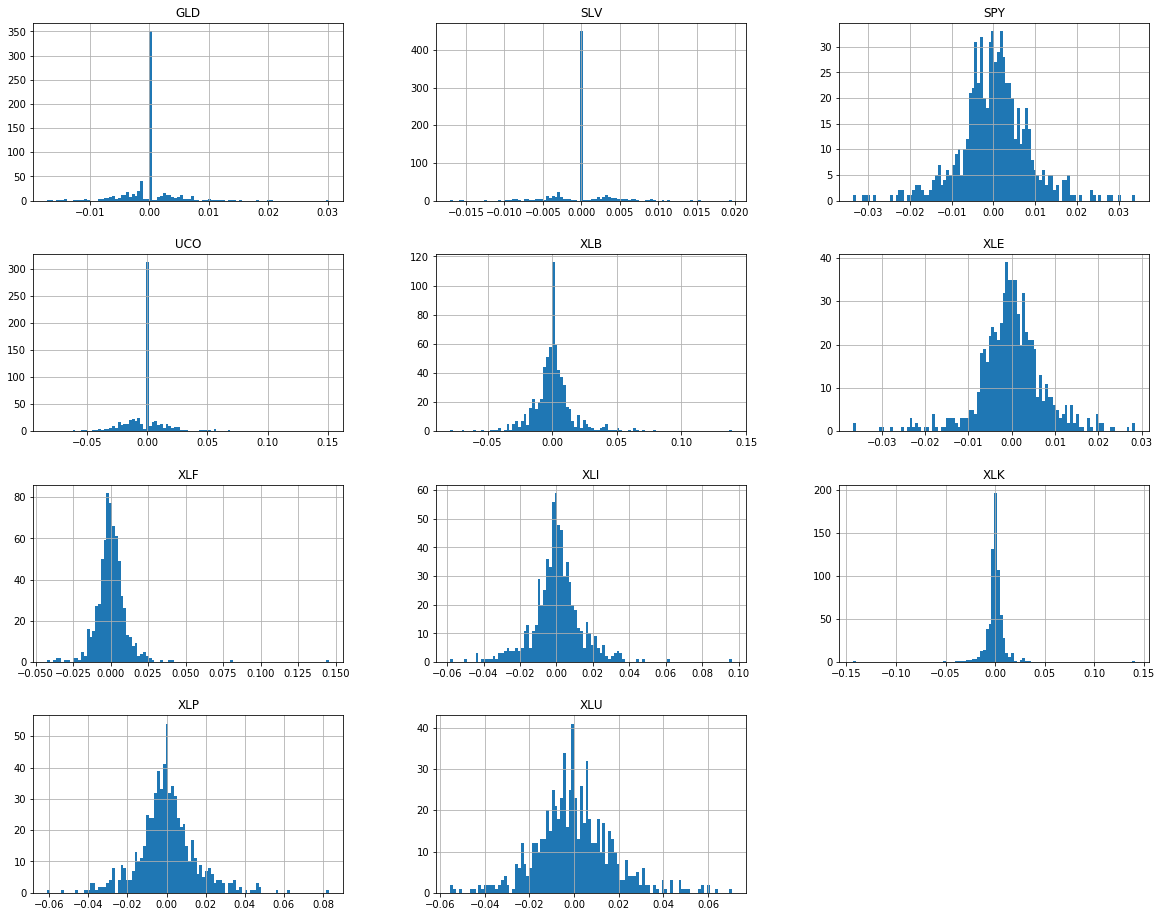

In [16]:
df_pc_all.hist(bins=100,figsize=(20,16))

___
## Process CFTC COT Data
___

### Initial processing
1. Download zip files from www.cft.gov/files;
2. Unip the files using the zipfile package;
3. Read each csv (usually named Annual.TXT), and merge them into the df_cot DataFrame.


In [31]:
year_list = np.linspace(2000,2019,20)
directory_to_extract_to = './'
download_folder = '.'
annual_path = f'{download_folder}/Annual.TXT'
df_cot_temp = None
df_cot = None
for y in year_list:
    yint = int(y)
    url = f"https://www.cftc.gov/files/dea/history/deacot{yint}.zip"
    path_to_zip_file = f'./dea_fut_xls_{y}.zip'
    print(f'retrieving cot zip file from {url}')
    try:
        urllib.request.urlretrieve(url, path_to_zip_file)    
    except:
        import time
        time.sleep(1)
        urllib.request.urlretrieve(url, path_to_zip_file)    
    zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
    zip_ref.extractall(directory_to_extract_to)
    zip_ref.close()
    df_cot_temp = pd.read_csv(annual_path)
    if df_cot is None:
        df_cot = df_cot_temp.copy()
    else:
        df_cot = df_cot.append(df_cot_temp,ignore_index=True)
        df_cot.index = list(range(len(df_cot)))
    print(f'processed cot csv file from {url}. Length = {len(df_cot_temp)}')    
# df_cot = pd.read_excel('/users/bperlman1/downloads/annual.xls')
df_cot.head()

retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2000.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2000.zip. Length = 3261
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2001.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2001.zip. Length = 2782
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2002.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2002.zip. Length = 2854
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2003.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2003.zip. Length = 3135
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2004.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2004.zip. Length = 3465
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2005.zip
processed cot csv

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3,37,38,39,40,41,42,43,44,45,46,126) have mixed types. Specify dtype option on import or set low_memory=False.



processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2017.zip. Length = 12314
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2018.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2018.zip. Length = 13410
retrieving cot zip file from https://www.cftc.gov/files/dea/history/deacot2019.zip
processed cot csv file from https://www.cftc.gov/files/dea/history/deacot2019.zip. Length = 994


,Total Reportable Positions-Long (All),% of OI-Commercial-Long (All),% of OI-Commercial-Long (Old),% of OI-Commercial-Long (Other),% of OI-Commercial-Short (All),% of OI-Commercial-Short (Old),% of OI-Commercial-Short (Other),% of OI-Noncommercial-Long (All),% of OI-Noncommercial-Long (Old),% of OI-Noncommercial-Long (Other),...,Traders-Noncommercial-Spreading (Other),Traders-Total (All),Traders-Total (Old),Traders-Total (Other),Traders-Total Reportable-Long (All),Traders-Total Reportable-Long (Old),Traders-Total Reportable-Long (Other),Traders-Total Reportable-Short (All),Traders-Total Reportable-Short (Old),Traders-Total Reportable-Short (Other)
0,91131,38.5,34.7,51.7,50.6,52.1,45.3,19.6,27.9,25.4,...,11,258,247,124,184,158,56,161,129,88
1,92861,38.0,35.3,48.0,46.6,47.4,43.9,19.5,27.0,28.6,...,10,262,252,118,183,160,52,166,133,86
2,93521,39.0,36.6,48.3,49.7,51.0,44.5,20.3,27.8,28.1,...,8,256,245,109,178,156,45,157,126,81
3,94501,37.3,35.0,47.0,50.4,52.3,42.5,21.2,28.3,29.9,...,10,261,250,110,188,164,43,165,136,84
4,101399,37.6,35.8,46.1,48.9,50.4,41.2,16.7,21.9,32.0,...,13,261,251,116,192,177,48,173,144,88


___
### Make column names easier to process, make main date field a datetime object, and sort the DataFrame
___

In [47]:
col_rename_dict = {c:c.replace(' ','_').replace('-','_').replace('(','').replace(')','') for c in df_cot.columns.values}
df_cot2 = df_cot.rename(columns=col_rename_dict)
def str_to_date(d):
    try:
        dt = datetime.datetime.strptime(str(d),'%Y-%m-%d')
    except:
        return None
    return dt
df_cot2.As_of_Date_in_Form_YYYY_MM_DD = df_cot2.As_of_Date_in_Form_YYYY_MM_DD.apply(str_to_date)
df_cot2 = df_cot2.sort_values(['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD'])
df_cot2.columns.values


array(['_Total_Reportable_Positions_Long_All',
       '%_of_OI_Commercial_Long_All', '%_of_OI_Commercial_Long_Old',
       '%_of_OI_Commercial_Long_Other', '%_of_OI_Commercial_Short_All',
       '%_of_OI_Commercial_Short_Old', '%_of_OI_Commercial_Short_Other',
       '%_of_OI_Noncommercial_Long_All', '%_of_OI_Noncommercial_Long_Old',
       '%_of_OI_Noncommercial_Long_Other',
       '%_of_OI_Noncommercial_Short_All',
       '%_of_OI_Noncommercial_Short_Old',
       '%_of_OI_Noncommercial_Short_Other',
       '%_of_OI_Noncommercial_Spreading_All',
       '%_of_OI_Noncommercial_Spreading_Old',
       '%_of_OI_Noncommercial_Spreading_Other',
       '%_of_OI_Nonreportable_Long_All', '%_of_OI_Nonreportable_Long_Old',
       '%_of_OI_Nonreportable_Long_Other',
       '%_of_OI_Nonreportable_Short_All',
       '%_of_OI_Nonreportable_Short_Old',
       '%_of_OI_Nonreportable_Short_Other',
       '%_of_OI_Total_Reportable_Long_All',
       '%_of_OI_Total_Reportable_Long_Old',
       '%_of_OI_Tot

___
### Show important columns for a specific  commodity
___

In [78]:
# commod = 'CRUDE OIL, LIGHT SWEET'
commod = 'GOLD'
cot_beg_date = datetime.datetime.now() - datetime.timedelta(200)
df_commod = df_cot2[df_cot2.Market_and_Exchange_Names.str.contains(commod)][df_cot2.As_of_Date_in_Form_YYYY_MM_DD>=cot_beg_date]
basic_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD','Open_Interest_All']
long_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD',
            'Noncommercial_Positions_Long_All','Commercial_Positions_Long_All',
            'Nonreportable_Positions_Long_All','Traders_Commercial_Long_All',
             'Traders_Noncommercial_Long_All','Traders_Total_Reportable_Long_All']
short_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD',
            'Noncommercial_Positions_Short_All','Commercial_Positions_Short_All',
            'Nonreportable_Positions_Short_All','Total_Reportable_Positions_Short_All',
            'Traders_Commercial_Short_All','Traders_Noncommercial_Short_All',
            'Traders_Total_Reportable_Short_All']
df_commod_basic = df_commod[basic_cols]
df_commod_long = df_commod[long_cols]
df_commod_short = df_commod[short_cols]


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



### Show basic open interest info

In [79]:
df_commod_basic.head()

,Market_and_Exchange_Names,As_of_Date_in_Form_YYYY_MM_DD,Open_Interest_All
133062,GOLD - COMMODITY EXCHANGE INC.,2018-08-07,459474
133061,GOLD - COMMODITY EXCHANGE INC.,2018-08-14,476739
133060,GOLD - COMMODITY EXCHANGE INC.,2018-08-21,483730
133059,GOLD - COMMODITY EXCHANGE INC.,2018-08-28,479283
133058,GOLD - COMMODITY EXCHANGE INC.,2018-09-04,473118


### Show important "long" position info

In [80]:
df_commod_long.head()

,Market_and_Exchange_Names,As_of_Date_in_Form_YYYY_MM_DD,Noncommercial_Positions_Long_All,Commercial_Positions_Long_All,Nonreportable_Positions_Long_All,Traders_Commercial_Long_All,Traders_Noncommercial_Long_All,Traders_Total_Reportable_Long_All
133062,GOLD - COMMODITY EXCHANGE INC.,2018-08-07,208292,154203,48402,54,160,261
133061,GOLD - COMMODITY EXCHANGE INC.,2018-08-14,211779,164195,46373,50,162,254
133060,GOLD - COMMODITY EXCHANGE INC.,2018-08-21,213500,166529,44895,50,175,270
133059,GOLD - COMMODITY EXCHANGE INC.,2018-08-28,207370,165581,45508,56,181,280
133058,GOLD - COMMODITY EXCHANGE INC.,2018-09-04,199762,168732,49169,54,163,255


### Show important "short" position info

In [81]:
df_commod_short.head()

,Market_and_Exchange_Names,As_of_Date_in_Form_YYYY_MM_DD,Noncommercial_Positions_Short_All,Commercial_Positions_Short_All,Nonreportable_Positions_Short_All,Total_Reportable_Positions_Short_All,Traders_Commercial_Short_All,Traders_Noncommercial_Short_All,Traders_Total_Reportable_Short_All
133062,GOLD - COMMODITY EXCHANGE INC.,2018-08-07,195604,179812,35481,423993,45,103,191
133061,GOLD - COMMODITY EXCHANGE INC.,2018-08-14,215467,171545,35335,441404,44,115,206
133060,GOLD - COMMODITY EXCHANGE INC.,2018-08-21,222210,168214,34500,449230,41,115,205
133059,GOLD - COMMODITY EXCHANGE INC.,2018-08-28,210433,173843,34183,445100,42,100,195
133058,GOLD - COMMODITY EXCHANGE INC.,2018-09-04,213259,162207,42197,430921,47,107,199


### Show important "net" position info

In [82]:
def non_comm_net(r):
    return float(r.Noncommercial_Positions_Long_All) - float(r.Noncommercial_Positions_Short_All)
def comm_net(r):
    return float(r.Commercial_Positions_Long_All) - float(r.Commercial_Positions_Short_All)
def non_report_net(r):
    return float(r.Nonreportable_Positions_Long_All) - float(r.Nonreportable_Positions_Short_All)
def traders_comm_net(r):
    return float(r.Traders_Commercial_Long_All) - float(r.Traders_Commercial_Short_All)
def traders_noncomm_net(r):
    return float(r.Traders_Noncommercial_Long_All) - float(r.Traders_Noncommercial_Short_All)

df_commod_net = df_commod_long.merge(df_commod_short,how='inner',on=['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD'])
df_commod_net['Noncommercial_Positions_Net_All'] = df_commod_net.apply(non_comm_net,axis=1)
df_commod_net['Commercial_Positions_Net_All'] = df_commod_net.apply(comm_net,axis=1)
df_commod_net['Nonreportable_Positions_Net_All'] = df_commod_net.apply(non_report_net,axis=1)
df_commod_net['Traders_Commercial_Net_All'] = df_commod_net.apply(traders_comm_net,axis=1)
df_commod_net['Traders_Noncommercial_Net_All'] = df_commod_net.apply(traders_noncomm_net,axis=1)
net_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD','Noncommercial_Positions_Net_All','Commercial_Positions_Net_All','Nonreportable_Positions_Net_All','Traders_Commercial_Net_All','Traders_Noncommercial_Net_All']
df_commod_net = df_commod_net[net_cols]
df_commod_net.tail()


,Market_and_Exchange_Names,As_of_Date_in_Form_YYYY_MM_DD,Noncommercial_Positions_Net_All,Commercial_Positions_Net_All,Nonreportable_Positions_Net_All,Traders_Commercial_Net_All,Traders_Noncommercial_Net_All
21,GOLD - COMMODITY EXCHANGE INC.,2018-12-31,123772.0,-144614.0,20842.0,-2.0,126.0
22,GOLD - COMMODITY EXCHANGE INC.,2019-01-08,99216.0,-121187.0,21971.0,4.0,103.0
23,GOLD - COMMODITY EXCHANGE INC.,2019-01-15,87913.0,-108113.0,20200.0,1.0,114.0
24,GOLD - COMMODITY EXCHANGE INC.,2019-01-22,74504.0,-92077.0,17573.0,-8.0,99.0
25,GOLD - COMMODITY EXCHANGE INC.,2019-01-29,99593.0,-118609.0,19016.0,-5.0,121.0


In [83]:
djan1 = datetime.datetime(2018,1,1)
djan2 = datetime.datetime(2019,2,28)
c1 = df_final2.symbol=='GLD'
c2 = df_final2.date>=djan1
c3 = df_final2.date<=djan2
c4 = df_final2.pc >= .009
allc = (c1) & (c2) & (c3) & (c4)
df_final2[allc]

,symbol,date,nav,shares,pc,share_diff
9121,GLD,2018-01-18,126.419184,284800000.0,0.014245,4000000.0
9162,GLD,2018-03-19,124.458023,288400000.0,0.012640,3600000.0
9305,GLD,2018-10-10,112.461736,251000000.0,0.012097,3000000.0
9353,GLD,2018-12-18,117.833453,262400000.0,0.010786,2800000.0
9358,GLD,2018-12-26,119.236762,268600000.0,0.020517,5400000.0
9362,GLD,2019-01-02,121.274806,270400000.0,0.009709,2600000.0
9374,GLD,2019-01-18,121.376456,275400000.0,0.015112,4100000.0
9380,GLD,2019-01-29,123.569123,280200000.0,0.010094,2800000.0


In [58]:
135000000*10  / (55 * 1000)

24545.454545454544

In [37]:
1600000000/55000

29090.909090909092